# Plot results for Aintelope
Run these blocks for all tests, then scroll to the title you're interested in:


In [1]:
%%capture
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from matplotlib import cm
import matplotlib.collections as mcoll
import matplotlib.path as mpath

from torch import Tensor

import dateutil.parser as dparser
import sys
import os

import seaborn as sns

from aintelope.training.lightning_trainer import DQNLightning
from aintelope.agents.memory import ReplayBuffer
import aintelope.agents
from aintelope.agents import get_agent_class
#from aintelope.agents.inference_agent import InferenceAgent
from aintelope.environments.savanna_gym import SavannaGymEnv
from omegaconf import DictConfig, OmegaConf

In [2]:
root_dir = os.path.split(os.path.split(os.getcwd())[0])[0]

if root_dir not in sys.path:
    sys.path.append(root_dir)

In [20]:
outputs_dir = root_dir+'/outputs/' 
available_records = os.listdir(outputs_dir)
print(available_records)

dirs = [os.path.join(outputs_dir, f) for f in available_records] # add path to each file
dirs.sort(key=lambda x: os.path.getmtime(x))
conf_dir = root_dir+'/aintelope/config/config_instinct_experiment.yaml'

['hunger_20231007165954', 'hunger_20231007170004']


# Old plots

In [21]:
latest_exp_dir = dirs[-1]
print(latest_exp_dir)
print(dparser.parse(latest_exp_dir,fuzzy=True))
df = pd.read_csv(latest_exp_dir+"/memory_records.csv")
print(df.columns)

/home/joel/project/aintelope/outputs/hunger_20231007170004
2023-10-07 17:00:04
Index(['state', 'action', 'reward', 'done', 'instinct_events', 'new_state'], dtype='object')


In [4]:
%%capture
'''
WIP, plot what the agent sees (needs changes to InferenceAgent etc.)
Check action values per location. Now expected reward for moving into location, but could also be
eating in any location, or of course mapping where the food/agents are. 
'''
cfg = OmegaConf.load(conf_dir)

# load environment agent
env = SavannaGymEnv(env_params=cfg.hparams.env_params)
env.reset() #this is also init...
# get the brains from memory checkpoints
model = DQNLightning.load_from_checkpoint(latest_exp_dir+"/checkpoints/last.ckpt")
# disable randomness, dropout, etc...
model.eval()

In [5]:
from collections import namedtuple

keys = (["agent_coords"] + 
        [f"grass_patch_{i}" for i in range(env.metadata["amount_grass_patches"])] + 
        [f"water_hole_{i}" for i in range(env.metadata["amount_water_holes"])])
StateTuple = namedtuple("StateTuple", {k: np.ndarray for k in keys})

x = []
y = []
event_x = []
event_y = []
event_type = []
food_x = []
food_y = []
water_x = []
water_y = []
for _ ,row in df.iterrows():
    
    state = eval(row['state'])
    
    x.append(state[0][0])
    y.append(state[0][1])
    
    #refactor
    food_x.append(state[1][0])
    food_y.append(state[1][1])
    #food_x.append(state[2][0])
    #food_y.append(state[2][1])    

    if row['instinct_events'] != '[]':
        event_x.append(x[-1])
        event_y.append(y[-1])
        event_type.append(row['instinct_events'])

In [6]:
agent_df = pd.DataFrame(data={'x':x, 'y':y})
print(agent_df.head(), len(agent_df))

food_df = pd.DataFrame(data={'x':food_x, 'y':food_y})
print(food_df.head(), len(food_df))

#water_df = pd.DataFrame(data={'x':water_x, 'y':water_y})
#print(water_df.head(), len(water_df))

     x    y
0  2.0  0.0
1  3.0  0.0
2  3.0  0.0
3  3.0  1.0
4  3.0  0.0 640
     x    y
0  2.0  0.0
1  2.0  0.0
2  2.0  0.0
3  2.0  0.0
4  2.0  0.0 640


In [7]:
event_df = pd.DataFrame(data={'x':event_x, 'y':event_y, 'event_type':event_type})
print(len(event_df))
print(event_df.head())

0
Empty DataFrame
Columns: [x, y, event_type]
Index: []


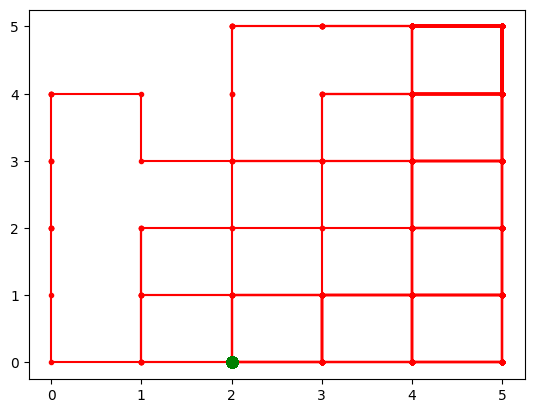

In [8]:
plt.plot(agent_df['x'], agent_df['y'], '.r-')
plt.plot(food_df['x'], food_df['y'], '.g', markersize=15)
#plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

<Axes: >

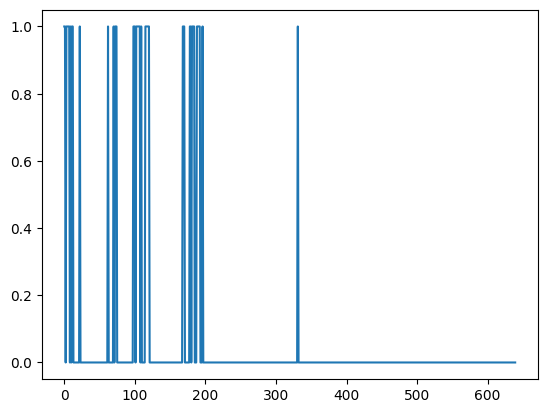

In [9]:
# plot reward received over time
df['reward'].plot()


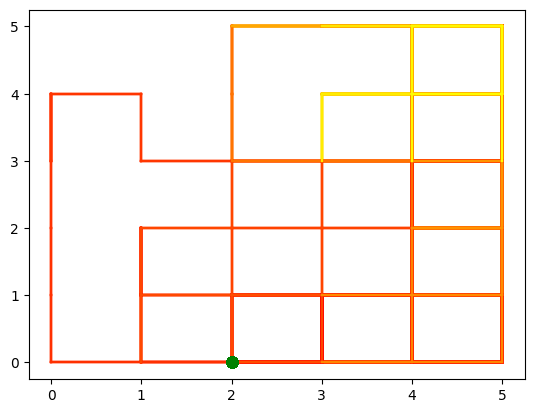

In [10]:
color_map = 'autumn' # starts yellow, goes orange, then red
n_points = len(agent_df)

fig = plt.figure()
ax1 = fig.add_subplot(111) 
cm = plt.get_cmap(color_map)
for i in range(10):
    ax1.set_prop_cycle('color', cm(np.linspace(0, 1, n_points - 1, endpoint=False)))
    for i in range(n_points - 1):
        plt.plot(agent_df['x'][i:i+2], agent_df['y'][i:i+2])
plt.plot(food_df['x'], food_df['y'], '.g', markersize=15)
#plt.plot(water_df['x'], water_df['y'], '.b', markersize=15)
plt.show()

# Valuemaps for actions
Note, these maps are new ones and don't correlate with the above ones as we randomly regenerate them.

In [20]:
%%capture
'''
WIP, plot what the agent sees (needs changes to InferenceAgent etc.)
Check action values per location. Now expected reward for moving into location, but could also be
eating in any location, or of course mapping where the food/agents are. 
'''
cfg = OmegaConf.load(conf_dir)

# load environment agent
env = SavannaGymEnv(env_params=cfg.hparams.env_params)
env.reset() #this is also init...
# get the brains from memory checkpoints
model = DQNLightning.load_from_checkpoint(latest_exp_dir+"/checkpoints/last.ckpt")
# disable randomness, dropout, etc...
model.eval()

In [21]:
# move the agent into each square and ask for its values for each action, then add that direction into the map
valuemap = np.zeros((env.metadata['map_max']+2,env.metadata['map_max']+2,4))
agent = env.agents[0]

ACTION_MAP = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]]) # This is a copy from savanna.py, should be an accessible param
for x in range(0, env.metadata['map_max']):
    for y in range(0, env.metadata['map_max']):
        if (env.grass_patches == [x,y]).all(1).any():
            continue
        if (env.water_holes == [x,y]).all(1).any():
            continue
        env.set_agent_position(agent, np.array([x,y]))
        observation = env.observe(agent)
        #print(env.agent_states[agent])
        action_vals = model(Tensor(observation)).detach().numpy()
        offset = ACTION_MAP
        for action in range(len(ACTION_MAP)):
            x_ = offset[action][0]+x
            y_ = offset[action][1]+y
            valuemap[x_,y_,action] = action_vals[action]
            
valuemap = np.sum(valuemap,2)/len(ACTION_MAP)

#print(valuemap)

<Axes: >

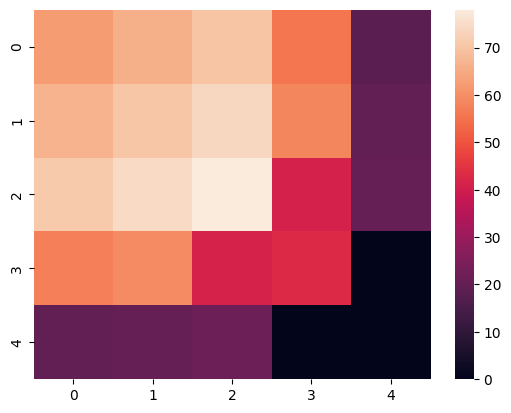

In [22]:
sns.heatmap(valuemap[1:-1,1:-1])

4.0


<Axes: >

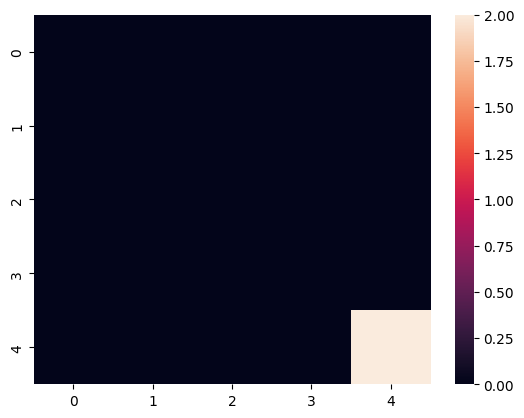

In [14]:
#env.render() isnt working atm
maps = np.zeros((env.metadata['map_max'],env.metadata['map_max']))
for grs in env.grass_patches:
    print(grs[0])
    maps[int(grs[0]),int(grs[1])] = 2.0
for wtr in env.water_holes:
    maps[int(wtr[0]),int(wtr[1])] = 4.0
sns.heatmap(maps)
# RED FOOD, LIGHT water

In [15]:
env.set_agent_position(agent, np.array([2,2]))
observation = env.observe(agent)
action_vals = model(Tensor(observation)).detach().numpy()
print(action_vals)

[71.58187 74.94384 66.77259 65.8634 ]


# Model performance plots
These plots don't have the exploration bonus as confabulators (such as epsilon-greedy).
Run the model N times, then change n_latest to this N and run the block.

In [7]:
def testrun(model,env):
    # Run each model for 10 different resets, with 10 different locations on the map.
    # Gather the cumulative reward, -1 has to be given on each step though
    # Or reset each time the food is found?
    agent = get_agent_class(cfg.hparams.agent_id)(
        env,
        model,
        ReplayBuffer(cfg.hparams.replay_size),
        0,#hparams.warm_start_steps,
        #hparams.agent_params,
    )
    #agent = env.agents[0]
    #print(env.agents)
    ACTION_MAP = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]]) 
    epsilon = 0.0
    device = "cpu"
    start_pos = [[0,0],
                [env.metadata['map_max'],env.metadata['map_max']],
                [env.metadata['map_max'],0],
                [0,env.metadata['map_max']]
                ] #list of starting positions for agent, to test robustly each model
    results = []
    rewards = []
    for j in range(len(start_pos)):
        agent.reset()
        env.set_agent_position(agent, np.array(start_pos[j]))
        score = 0
        for i in range(20):
            reward, done = agent.play_step(model, epsilon, device)
            rewards.append(reward)
            score -= 1 # to make sure that longer play is penalized? TODO
            if reward > 0:
                break
        results.append(score)
    return results, rewards


In [13]:
%%capture
# Load all the models. Note that to make a statistical thing, run the training several times and then
# take N-latest.
n_latest = 5 # sample of n runs you've just 'make run-training'ed a moment ago
latest_dirs = dirs[-n_latest:-1]

# Read and sort models for testing
models = []
for exp_dir in latest_dirs:
    mod_dir = os.listdir(exp_dir+"/checkpoints/")
    runs_dir = [os.path.join(exp_dir+"/checkpoints/", m) for m in mod_dir]
    runs_dir.sort(key=lambda x: os.path.getmtime(x))
    models.append(runs_dir)

cfg = OmegaConf.load(conf_dir)
env = SavannaGymEnv(env_params=cfg.hparams.env_params)

results = np.zeros([len(models),len(models[0])])
rewards = []
for i in range(len(models)): # statistical significance
    for j in range(len(models[0])): # number of epochs per run
        model = DQNLightning.load_from_checkpoint(models[i][j])
        model.eval()
        # run model
        result, reward = testrun(model, env)
        rewards.append(reward)
        results[i,j] = sum(result)

In [14]:
print(rewards)

[[1, 1, 1, 0, 0, 1], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]]


In [15]:
# Plot results
print(results)
print(results.mean(axis=1))
print(results.var(axis=1))
event_df = pd.DataFrame(data={'x':event_x, 'y':event_y})
df['reward'].plot()
# what are these rewards?
# which way is the matrix?
# you should do preset envs with static distances
# check agent epsilon
# add nosmell smell to agent somehow
# figure out REWARD...
# qagent 120 add reward for emotions
#print(agent.)

[[ -6. -61. -62. -12.]]
[-35.25]
[693.6875]


NameError: name 'event_x' is not defined

In [16]:
hparams = cfg.hparams
print(hparams.agent_params)

{'target_instincts': ['smell']}
